In [16]:
import ast
import spacy
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [6]:
df_sentiment = pd.read_csv("VADER_labeled_data.csv")
df_sentiment["label"] = df_sentiment["sentiment_compound"]

<AxesSubplot:ylabel='Density'>

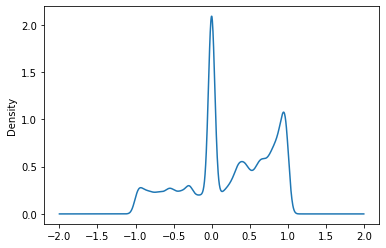

In [8]:
df_sentiment["label"].plot(kind="kde")

In [9]:
# initialize spacy:
nlp = spacy.load("en_core_web_sm")

# vectorize data:

df_sentiment["doc"] =  [doc for doc in tqdm(nlp.pipe(df_sentiment["comment"], n_process=-1))]
# exclude validation data:
validation = df_sentiment.sample(int(df_sentiment.shape[0]*0.1))
train_test_df = df_sentiment[~df_sentiment.index.isin(validation.index)]

404362it [51:23, 131.13it/s]


In [10]:
X = np.array([d.vector for d in train_test_df["doc"]])
y = train_test_df["label"].values

# Test Train Split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Split validation data
X_validation = np.array([d.vector for d in validation["doc"]])
y_validation = validation["label"].values

In [11]:
# Train and tune model:
xgb = XGBRegressor()

params = {
        'min_child_weight': [0.3],
        'gamma': [0.001],
        'max_depth': [15],
        }

grid = GridSearchCV(estimator=xgb, param_grid=params, n_jobs=-1, verbose=3, cv=3)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [13]:
grid.best_params_

{'gamma': 0.001, 'max_depth': 15, 'min_child_weight': 0.3}

In [18]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#   print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [19]:
XGB_best = XGBRegressor(**grid.best_params_)
XGB_best.fit(X_train, y_train)
y_pred = XGB_best.predict(X_test)

regression_results(y_test, y_pred)

explained_variance:  0.1679
r2:  0.1679
MAE:  0.3687
MSE:  0.256
RMSE:  0.506


In [ ]:
XGB_final = XGBRegressor(**grid.best_params_)
XGB_final.fit(X, y)
y_pred = XGB_final.predict(X_validation)

regression_results(y_validation, y_pred)

In [18]:
# train and persist model
X_full = np.array([d.vector for d in df_sentiment["doc"]])
y_full = df_sentiment["label"].values
xgb = XGBRegressor(**grid.best_params_)
xgb.fit(X_full,y_full)

pickle.dump(xgb, open("../resource/models/sentiment_model.pkl", "wb"))


C:\Users\bjarn\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:09:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
